In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
# make plots have a dark theme
plt.style.use('dark_background')
import glob
from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
from astropy.cosmology import LambdaCDM, z_at_value
cosmo = LambdaCDM(H0=69.6, Om0=0.286, Ode0=0.714)
h = 69.6/100

from alignment_functions.gal_groups import *
from geometry_functions.coordinate_functions import *
from visualization_functions import *
from alignment_functions.general_stats import *
from alignment_functions.basic_alignment import *

In [3]:
scratch_path = '/pscratch/sd/c/clamman/'

In [4]:
desi_catalog = Table.read(scratch_path+'Iron_LRG_noCircles.csv') 
desi_catalog.keep_columns(['RA', 'DEC', 'Z'])

### Finding groups

Find set of groups with: 
- transverse separations < 0.5 Mpc/h
- LOS separations < 6 Mpc/h
- (optional) no other groups within 1 Mpc/h transverse  (** no other galaxy)

In [5]:
desi_points = get_cosmo_points(desi_catalog)  # convert to comoving cartesian points in Mpc/h, assumes oberver is at orgin

In [6]:
# group PARAMETERS

# requirements for group members relative to center of group
transverse_max = 0.5                            
los_max = 6

group_transverse_minSep = transverse_max * 2  # minimum separation between groups
max_n = 10                                      # maximum number of group members

In [7]:
# finding initial group list
desi_groups = find_groups_UnionFind(desi_points, max_n = max_n, transverse_max = transverse_max, los_max = los_max)

In [8]:
desi_groups_isolated = remove_close_groups(desi_points, desi_groups, group_transverseSep_min=group_transverse_minSep, max_n=max_n, los_max=100)

/global/u1/c/clamman/IA/spec-IA/geometry_functions/coordinate_functions.py:137: RuntimeWarning: invalid value encountered in true_divide
  proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)


Number of groups found:  59829
	Group Requirements
	maximum transverse between group members:	 0.5  Mpc/h 
	maximum los distance between group members:		 6  Mpc/h
Number of isolated groups:  46742
	Isolated group requirements
	minimum distance between group center and a galaxy outside the group:	 1.0  Mpc/h


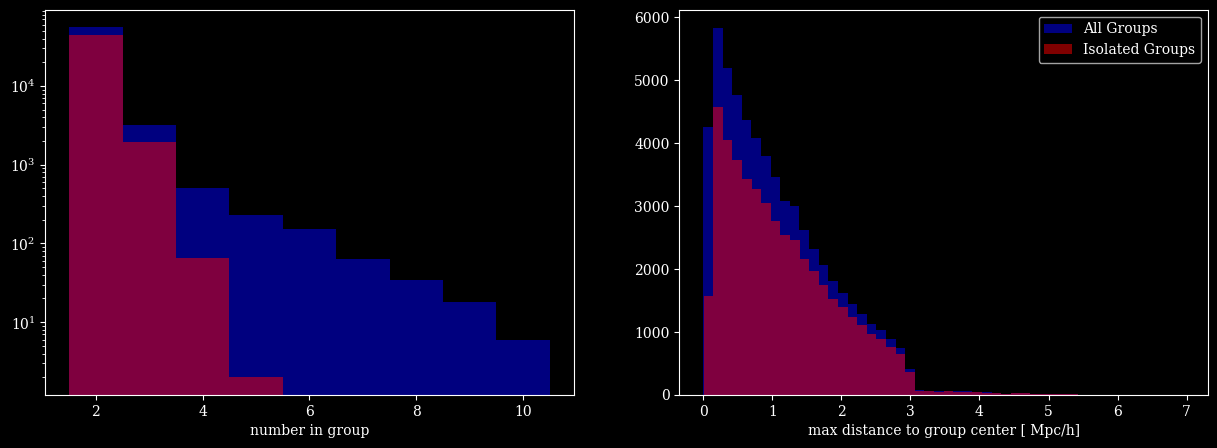

In [9]:
points = desi_points

# plot summaries of groups
print('Number of groups found: ', len(desi_groups))
print('\tGroup Requirements\n\tmaximum transverse between group members:\t', transverse_max, ' Mpc/h',
      '\n\tmaximum los distance between group members:\t\t', los_max, ' Mpc/h')
print('Number of isolated groups: ', len(desi_groups_isolated))
print('\tIsolated group requirements\n\tminimum distance between group center and a galaxy outside the group:\t', group_transverse_minSep, ' Mpc/h')

# look at groupemographics
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist([len(cl) for cl in desi_groups], alpha=.5, label='All Cluters', bins=np.arange(1.5, 11, 1), color='b')
plt.hist([len(cl) for cl in desi_groups_isolated], alpha=.5, label='Isolated Cluters', bins=np.arange(1.5, 11, 1), color='r')
plt.xlabel('number in group')
plt.yscale('log')

plt.subplot(122)
plt.xlabel('max distance to group center [ Mpc/h]')
# find the maximum distance between group members
group_distances = []
for cl in desi_groups:
    group_center = np.mean(points[cl], axis=0)
    distance_to_center = np.linalg.norm(points[cl] - group_center, axis=1)
    group_distances.append(np.max(distance_to_center))
plt.hist(group_distances, alpha=.5, label='All Groups', bins=50, color='b');

group_distances_isolated = []
for cl in desi_groups_isolated:
    group_center = np.mean(points[cl], axis=0)
    distance_to_center = np.linalg.norm(points[cl] - group_center, axis=1)
    group_distances_isolated.append(np.max(distance_to_center))
plt.hist(group_distances_isolated, alpha=.5, label='Isolated Groups', bins=50, color='r');
plt.legend()

fig.savefig('plots/group_stats.png', bbox_inches='tight')

### Measuring Group Alignment

In [10]:
# getting group orientations

def make_group_table(points, group_indices):
    group_table = Table()
    group_table['center_loc'] = [np.mean(points[cl], axis=0) for cl in group_indices]
    group_table['orientation'] = [calculate_2D_group_orientation(points[cl]) for cl in group_indices]
    group_table['n_group'] = [len(cl) for cl in group_indices]
    group_table['max_dist_to_center'] = [np.max(np.linalg.norm(points[cl] - group_table['center_loc'][i], axis=1)) for i, cl in enumerate(group_indices)]
    return group_table

group_table = make_group_table(points, desi_groups)
group_table_isolated = make_group_table(points, desi_groups_isolated)

In [11]:
group_seps, group_paRel = calculate_rel_ang_cartesian(ang_tracers = group_table['center_loc'], ang_values = group_table['orientation'], 
                                                      loc_tracers = desi_points, pimax = 20, max_proj_sep = 100, max_neighbors=1000)
group_seps_isolated, group_paRel_isolated = calculate_rel_ang_cartesian(ang_tracers = group_table_isolated['center_loc'], ang_values = group_table_isolated['orientation'],
                                                        loc_tracers = desi_points, pimax = 20, max_proj_sep = 100, max_neighbors=1000)

/global/u1/c/clamman/IA/spec-IA/geometry_functions/coordinate_functions.py:137: RuntimeWarning: invalid value encountered in true_divide
  proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)


(19654003, 2)
(13729735, 2)


In [12]:
# bin results
nbins=20
sep_bins = np.linspace(0.001, np.max(100), nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(group_seps, np.cos(2*group_paRel), sep_bins, statistic='mean', err=True)
ang_plot_isolated, ang_plot_e_isolated = bin_sum_not_scipy(group_seps_isolated, np.cos(2*group_paRel_isolated), sep_bins, statistic='mean', err=True)

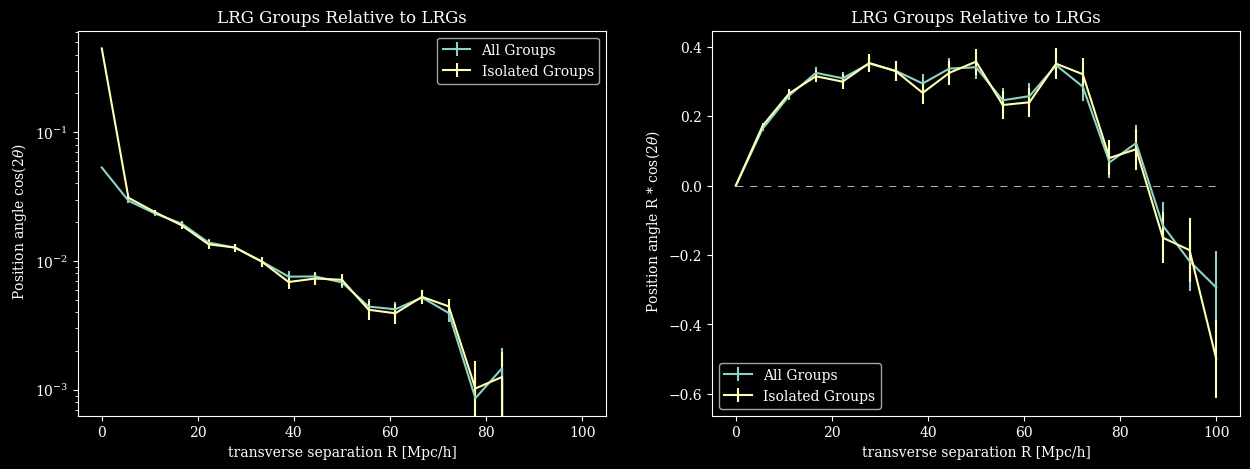

In [13]:
fig = plt.figure(figsize=(15,5))
xvalues = np.linspace(0, 100, nbins-1)

plt.subplot(121)
plt.title("LRG Groups Relative to LRGs")
plt.errorbar(xvalues, ang_plot, yerr=ang_plot_e, label='All Groups');
plt.errorbar(xvalues, ang_plot_isolated, yerr=ang_plot_e_isolated, label='Isolated Groups');
plt.yscale('log')
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r' Position angle cos(2$\theta$)')
plt.legend()


plt.subplot(122)
plt.title("LRG Groups Relative to LRGs")
plt.errorbar(xvalues, xvalues*ang_plot, yerr=xvalues*ang_plot_e, label='All Groups');
plt.errorbar(xvalues, xvalues*ang_plot_isolated, yerr=xvalues*ang_plot_e_isolated, label='Isolated Groups');
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r'Position angle R * cos(2$\theta$)')
# add dotted line at 0
# make dashes far apart
plt.plot([0,100], [0,0], color='w', linewidth=.5, zorder=0, dashes=(10, 10))

plt.legend();

fig.savefig('plots/LRG_group_alignment.png', bbox_inches='tight', dpi=200);

### group-group alignment

In [32]:
group_seps, group_paRel = calculate_rel_ang_cartesian(ang_tracers = group_table['center_loc'], ang_values = group_table['orientation'], 
                                                      loc_tracers = group_table['center_loc'], pimax = 20, max_proj_sep = 100, max_neighbors=1000)
group_seps_isolated, group_paRel_isolated = calculate_rel_ang_cartesian(ang_tracers = group_table_isolated['center_loc'], ang_values = group_table_isolated['orientation'],
                                                        loc_tracers = group_table_isolated['center_loc'], pimax = 20, max_proj_sep = 100, max_neighbors=1000)

/global/u1/c/clamman/IA/spec-IA/geometry_functions/coordinate_functions.py:137: RuntimeWarning: invalid value encountered in true_divide
  proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)


(3271098, 2)
(523174, 2)


In [33]:
# bin results
nbins=20
sep_bins = np.linspace(0.001, np.max(100), nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(group_seps, np.cos(2*group_paRel), sep_bins, statistic='mean', err=True)
ang_plot_isolated, ang_plot_e_isolated = bin_sum_not_scipy(group_seps_isolated, np.cos(2*group_paRel_isolated), sep_bins, statistic='mean', err=True)

/tmp/ipykernel_784355/4057438796.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,100], [0,0], 'k--', color='w', linewidth=.5, zorder=0, dashes=(10, 10))


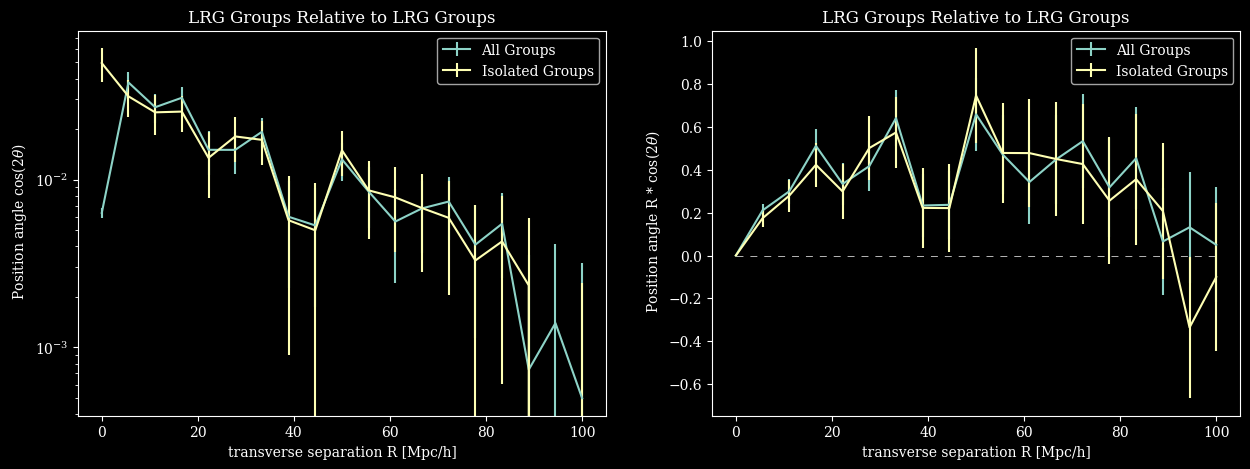

In [34]:
fig = plt.figure(figsize=(15,5))
xvalues = np.linspace(0, 100, nbins-1)

plt.subplot(121)
plt.title("LRG Groups Relative to LRG Groups")
plt.errorbar(xvalues, ang_plot, yerr=ang_plot_e, label='All Groups');
plt.errorbar(xvalues, ang_plot_isolated, yerr=ang_plot_e_isolated, label='Isolated Groups');
plt.yscale('log')
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r' Position angle cos(2$\theta$)')
plt.legend()


plt.subplot(122)
plt.title("LRG Groups Relative to LRG Groups")
plt.errorbar(xvalues, xvalues*ang_plot, yerr=xvalues*ang_plot_e, label='All Groups');
plt.errorbar(xvalues, xvalues*ang_plot_isolated, yerr=xvalues*ang_plot_e_isolated, label='Isolated Groups');
plt.xlabel('transverse separation R [Mpc/h]')
plt.ylabel(r' Position angle R * cos(2$\theta$)')
# add dotted line at 0
# make dashes far apart
plt.plot([0,100], [0,0], 'k--', color='w', linewidth=.5, zorder=0, dashes=(10, 10))

plt.legend();

#fig.savefig('plots/LRG_groupgroup_alignment.png', bbox_inches='tight')